In [107]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [108]:
# Import required Libraries
!pip install fastparquet
import math
import pandas_datareader as web
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime

In [0]:
stocks = pd.read_parquet('https://github.com/alik604/CMPT-419/blob/master/data/wsb.daily.joined.parquet.gz?raw=true', engine="fastparquet")

In [195]:
stocks.head(5)
stocks.tail(5)

,created_utc,score,gilded,wordcount,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,AAPL_CPrc,AAPL_OPrc,AMZN_CPrc,AMZN_OPrc,BA_CPrc,BA_OPrc,SPY_CPrc,SPY_OPrc,TSLA_CPrc,TSLA_OPrc
708,2019-10-25,5.419186,0.000254,15.673863,-0.015092,0.086603,-0.009423,-0.018914,-0.037407,-0.022757,0.150014,-0.074765,-0.021758,-0.006170,-0.043355,0.060446,-0.667465,-0.029348,0.042688,0.020240,0.046672,-0.046239,-0.001512,-0.014393,0.006396,0.018746,0.037486,0.030975,-0.051407,246.58,243.16,1761.33,1698.01,339.83,342.99,301.60,299.74,328.13,297.72
709,2019-10-28,5.501885,0.000092,16.153627,-0.012493,0.088967,-0.010182,-0.019853,-0.039271,-0.024242,0.149202,-0.081592,-0.018510,-0.005629,-0.040943,0.060828,-0.669622,-0.026370,0.043762,0.021522,0.047934,-0.044034,0.000773,-0.018675,0.005929,0.016296,0.038137,0.029383,-0.054537,249.05,247.50,1777.08,1750.70,340.88,341.49,303.30,302.91,327.71,327.35
710,2019-10-29,4.831472,0.000162,15.053424,-0.013019,0.089879,-0.008358,-0.017215,-0.038393,-0.022216,0.151195,-0.074344,-0.021114,-0.003404,-0.043528,0.062134,-0.665775,-0.031624,0.043718,0.024438,0.046891,-0.044923,0.001078,-0.015523,0.009790,0.019005,0.038384,0.031873,-0.050217,243.29,248.97,1762.71,1775.00,348.93,340.15,303.21,303.03,316.22,319.99
711,2019-10-30,5.048346,0.000181,14.314462,-0.006399,0.089110,-0.016125,-0.019654,-0.033241,-0.019550,0.140450,-0.045746,-0.022562,-0.003709,-0.045547,0.050558,-0.656832,-0.030471,0.037854,0.018806,0.033313,-0.042526,-0.004206,-0.004015,0.004740,0.010254,0.037975,0.031479,-0.046712,243.26,244.76,1779.99,1760.10,346.06,346.63,304.14,303.43,315.01,313.00
712,2019-10-31,9.800924,0.000872,17.253552,-0.013783,0.088982,-0.012983,-0.012372,-0.036133,-0.023620,0.154619,-0.076849,-0.023294,-0.003048,-0.041251,0.061375,-0.663991,-0.028172,0.043660,0.026479,0.046957,-0.043210,0.002582,-0.017126,0.007530,0.019177,0.033687,0.031406,-0.051298,248.76,247.20,1776.66,1775.99,339.91,344.70,303.33,304.11,314.92,313.10


In [0]:
# Drop created date 
data = stocks.drop(['created_utc', 'AAPL_CPrc','AMZN_CPrc','BA_CPrc', 'SPY_CPrc', 'TSLA_CPrc' ] , axis=1)

# Closing Price dataset
plotData = stocks.filter(['created_utc','AAPL_CPrc', 'AMZN_CPrc', 'BA_CPrc', 'SPY_CPrc', 'TSLA_CPrc'])
dataCPrc = stocks.filter(['AAPL_CPrc', 'AMZN_CPrc', 'BA_CPrc', 'SPY_CPrc', 'TSLA_CPrc'])
datasetCPrc = dataCPrc.values


In [197]:
dataset = data.values
print(dataset)

[[4.62113587e+00 0.00000000e+00 1.72465852e+01 ... 1.56300000e+02
  2.25070000e+02 2.15610000e+02]
 [5.84415584e+00 0.00000000e+00 1.69265951e+01 ... 1.57780000e+02
  2.25640000e+02 2.14300000e+02]
 [6.36900369e+00 0.00000000e+00 1.79852399e+01 ... 1.58410000e+02
  2.26280000e+02 2.26600000e+02]
 ...
 [4.83147159e+00 1.61890886e-04 1.50534240e+01 ... 3.40150000e+02
  3.03030000e+02 3.19990000e+02]
 [5.04834621e+00 1.81071946e-04 1.43144616e+01 ... 3.46630000e+02
  3.03430000e+02 3.13000000e+02]
 [9.80092391e+00 8.71611610e-04 1.72535518e+01 ... 3.44700000e+02
  3.04110000e+02 3.13100000e+02]]


In [198]:
# set training set len
training_data_len = math.ceil(len(dataset) * 0.8) 
training_data_len

571

In [199]:
# Scale data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scalerCPrc = MinMaxScaler(feature_range=(0,1))
scaledCPrc_data = scalerCPrc.fit_transform(datasetCPrc)
scaledCPrc_data

array([[9.77223183e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.84536233e-01],
       [0.00000000e+00, 2.73748882e-03, 5.81702803e-03, 1.69835234e-02,
        2.33072853e-01],
       [4.43508983e-03, 2.08344675e-02, 6.13432047e-03, 1.47021546e-02,
        2.31907975e-01],
       ...,
       [9.56701496e-01, 7.84733834e-01, 6.76749515e-01, 9.88212928e-01,
        6.66165122e-01],
       [9.56475983e-01, 7.98172415e-01, 6.66631412e-01, 1.00000000e+00,
        6.60292190e-01],
       [9.97820041e-01, 7.95582688e-01, 6.44949762e-01, 9.89733840e-01,
        6.59855361e-01]])

In [0]:
# Create training set from scaled data 
train_data = scaled_data[0:training_data_len, :]
train_y = scaledCPrc_data[0:training_data_len, :]

In [0]:
# Split data into x_train, y_train
x_train = []
y_train = []

In [202]:
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, :])
  y_train.append(train_y[i:i+1,:][0].tolist())
  if(i < 65):
    print(train_y[i:i+1,:][0], type(train_y[i:i+1,:][0]))

[0.20972713 0.09540771 0.07407016 0.1400507  0.47959035] <class 'numpy.ndarray'>
[0.20777268 0.10334798 0.07012163 0.13307985 0.48211426] <class 'numpy.ndarray'>
[0.20807337 0.10720535 0.06938128 0.1278834  0.5802553 ] <class 'numpy.ndarray'>
[0.21604149 0.11914298 0.0766085  0.12978454 0.60539727] <class 'numpy.ndarray'>
[0.21047884 0.121025   0.07089723 0.12091255 0.56205407] <class 'numpy.ndarray'>


In [203]:
# Convert both x, y training sets to np array 
x_train, y_train = np.array(x_train), np.array(y_train)
print(y_train, type(y_train))
# Reshape the data // LSTM network expects 3 dimensional input in the form of 
# (number of samples, number of timesteps, number of features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 33))
x_train.shape

[[0.20972713 0.09540771 0.07407016 0.1400507  0.47959035]
 [0.20777268 0.10334798 0.07012163 0.13307985 0.48211426]
 [0.20807337 0.10720535 0.06938128 0.1278834  0.5802553 ]
 ...
 [0.63188754 0.85251001 0.76696633 0.80544994 0.45736058]
 [0.62752763 0.84160672 0.74764675 0.78669202 0.45304082]
 [0.63594678 0.85054244 0.73319231 0.7991128  0.47124205]] <class 'numpy.ndarray'>


(511, 60, 33)

In [0]:
# Declare the LSTM model architecture 
model = Sequential()

# Add layers , input shape expected is (number of timesteps, number of features)
model.add(LSTM(75, return_sequences=True, input_shape=(x_train.shape[1], 33)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(5))

In [0]:
# Compile Model 
model.compile(optimizer='adam', loss='mean_squared_error')

In [206]:
# Train the model 
model.fit(x_train, y_train, batch_size=16, epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 57ms/step - loss: 0.0604
Epoch 2/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0106
Epoch 3/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0076
Epoch 4/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0061
Epoch 5/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0056
Epoch 6/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0049
Epoch 7/100
32/32 [==============================] - 2s 58ms/step - loss: 0.0044
Epoch 8/100
32/32 [==============================] - 2s 58ms/step - loss: 0.0043
Epoch 9/100
32/32 [==============================] - 2s 57ms/step - loss: 0.0039
Epoch 10/100
32/32 [==============================] - 2s 57ms/step - loss: 0.0041
Epoch 11/100
32/32 [==============================] - 2s 59ms/step - loss: 0.0039
Epoch 12/100
32/32 [==============================] - 3s 87ms/step - loss: 0.0037
Epoch 13/100
32/32 [=====

In [0]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
test_y = scaledCPrc_data[training_data_len-60:,:]
# Create the data sets x_test and y_test
x_test = []
y_test = []

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, :])
  y_test.append(train_y[i:i+1,:][0].tolist())

print(len(test))

In [0]:
# Convert the data into a np array
x_test = np.array(x_test)

# Reshape data into 3 dimensions ( num samples, timesteps, num features )
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 33))

In [0]:
# Get the models predicted price values 
predictions = model.predict(x_test)

# Inverse transform 
predictions = scalerCPrc.inverse_transform(predictions)


In [125]:
# Evaluate model with root mean square error (RMSE)
rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse

878.2621720539609

In [147]:
# Set up ploting dataset
plotData = stocks.filter(['created_utc','AAPL_CPrc', 'AMZN_CPrc', 'BA_CPrc', 'SPY_CPrc', 'TSLA_CPrc'])
plotData = plotData.set_index("created_utc")
print(plotData, type(plotData))

# This is so it graphs nicely with dates 
AAPL = plotData["AAPL_CPrc"]
AAPL = AAPL.to_frame()
AMZN = plotData["AMZN_CPrc"]
AMZN = AMZN.to_frame()
BA = plotData["BA_CPrc"]
BA = BA.to_frame();
SPY = plotData["SPY_CPrc"]
SPY = SPY.to_frame();
TSLA = plotData["TSLA_CPrc"]
TSLA = TSLA.to_frame()

appleTest = AAPL[0:training_data_len]
amazonTest = AMZN[0:training_data_len]
boeTest = BA[0:training_data_len]
spyTest = SPY[0: training_data_len]
teslaTest = TSLA[0: training_data_len]

appleValid = AAPL[training_data_len:]
amazonValid = AMZN[training_data_len:]
boeValid = BA[training_data_len:]
spyValid = SPY[training_data_len:]
teslaValid = TSLA[training_data_len:]
# print(appleValid)

appleValid['Predictions'] = predictions[:,:1]
amazonValid["Predictions"] = predictions[:,1:2]
boeValid['Predictions'] = predictions[:, 2:3]
spyValid["Predictions"] = predictions[:, 3:4]
teslaValid["Predictions"] = predictions[:, 4:5]
print(len(appleValid), len(predictions))


             AAPL_CPrc  AMZN_CPrc  BA_CPrc  SPY_CPrc  TSLA_CPrc
created_utc                                                    
2017-01-03      116.15     753.66   156.97    225.24     216.99
2017-01-04      116.02     757.18   158.62    226.58     226.99
2017-01-05      116.61     780.45   158.71    226.40     226.75
2017-01-06      117.91     795.99   159.10    227.21     229.01
2017-01-09      118.99     796.92   158.32    226.46     231.25
...                ...        ...      ...       ...        ...
2019-10-25      246.58    1761.33   339.83    301.60     328.13
2019-10-28      249.05    1777.08   340.88    303.30     327.71
2019-10-29      243.29    1762.71   348.93    303.21     316.22
2019-10-30      243.26    1779.99   346.06    304.14     315.01
2019-10-31      248.76    1776.66   339.91    303.33     314.92

[713 rows x 5 columns] <class 'pandas.core.frame.DataFrame'>
142 142


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

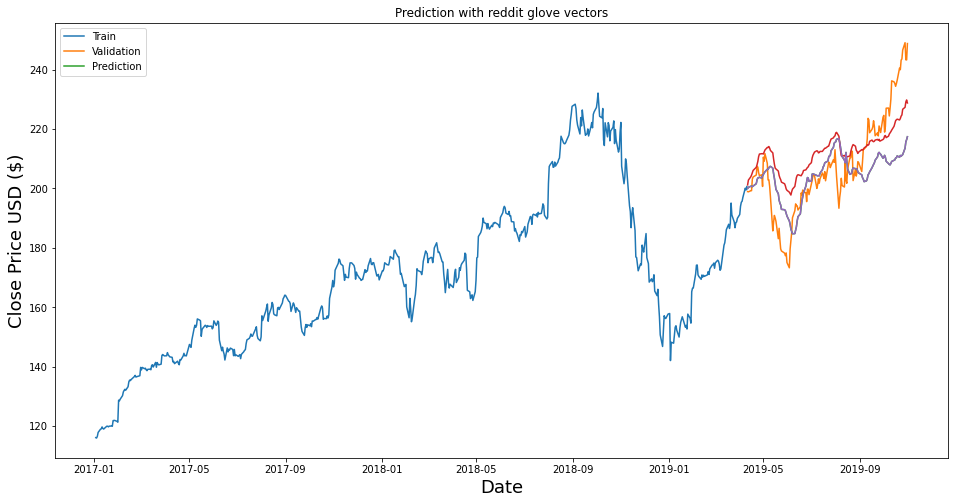

In [210]:
# Visualize data
plt.figure(figsize=(16,8))
plt.title('Prediction with reddit glove vectors')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(appleTest)
plt.plot(appleValid)
plt.plot(appleValid['Predictions'])
# plt.plot(amazonTest)
# plt.plot(amazonValid)
# plt.plot(amazonValid['Predictions'])
# plt.plot(boeTest)
# plt.plot(boeValid)
# plt.plot(boeValid['Predictions'])
# plt.plot(spyTest)
# plt.plot(spyValid)
# plt.plot(spyValid['Predictions'])
# plt.plot(teslaTest)
# plt.plot(teslaValid)
# plt.plot(teslaValid['Predictions'])
plt.legend(['Train', 'Validation', 'Prediction'])
plt.show()

In [0]:
# Lets train a model without reddit posts to see how it performs 
opening_prices = stocks.filter(['created_utc','AAPL_OPrc', 'AMZN_OPrc', 'BA_OPrc', 'SPY_OPrc', 'TSLA_OPrc'])
opening_prices = opening_prices.set_index('created_utc')
# PlotData contains closing prices 

In [129]:
opening_dataset = opening_prices.values
closing_dataset = plotData.values
print(opening_dataset)
print(closing_dataset)

[[ 115.8   758.    156.3   225.07  215.61]
 [ 115.8   758.39  157.78  225.64  214.3 ]
 [ 115.93  761.55  158.41  226.28  226.6 ]
 ...
 [ 248.97 1775.    340.15  303.03  319.99]
 [ 244.76 1760.1   346.63  303.43  313.  ]
 [ 247.2  1775.99  344.7   304.11  313.1 ]]
[[ 116.15  753.66  156.97  225.24  216.99]
 [ 116.02  757.18  158.62  226.58  226.99]
 [ 116.61  780.45  158.71  226.4   226.75]
 ...
 [ 243.29 1762.71  348.93  303.21  316.22]
 [ 243.26 1779.99  346.06  304.14  315.01]
 [ 248.76 1776.66  339.91  303.33  314.92]]


In [0]:
# set training set len
train_data_len = math.ceil(len(opening_dataset) * 0.80) 

In [0]:
openScaler = MinMaxScaler(feature_range=(0,1))
scaled_open_prices = openScaler.fit_transform(opening_dataset)

In [0]:
closeScaler = MinMaxScaler(feature_range=(0,1))
scaled_close_prices = closeScaler.fit_transform(closing_dataset)

In [153]:
o_train_data = scaled_open_prices[0:train_data_len, :]
c_train_data = scaled_close_prices[0:train_data_len,:]
print(o_train_data, len(o_train_data))
c_train_data

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.68423621e-01]
 [0.00000000e+00 3.04152856e-04 5.10855683e-03 7.21153846e-03
  1.62030259e-01]
 [9.76195840e-04 2.76857087e-03 7.28314521e-03 1.53087045e-02
  2.22059541e-01]
 ...
 [2.75587595e-01 6.90247612e-01 6.56518588e-01 3.95242915e-01
  7.49389946e-01]
 [2.78441090e-01 6.88282316e-01 6.62973318e-01 4.12196356e-01
  7.85700342e-01]
 [2.63197417e-01 6.68364204e-01 6.60073867e-01 4.02327935e-01
  7.87701318e-01]] 511


array([[0.00097722, 0.        , 0.        , 0.        , 0.18453623],
       [0.        , 0.00273749, 0.00581703, 0.01698352, 0.23307285],
       [0.00443509, 0.02083447, 0.00613432, 0.01470215, 0.23190797],
       ...,
       [0.28399609, 0.70191702, 0.68972325, 0.42636248, 0.80570791],
       [0.27264527, 0.68973831, 0.69074564, 0.42762991, 0.81682279],
       [0.25543111, 0.67157911, 0.68179094, 0.40760456, 0.7544047 ]])

In [134]:
o_x_train = []
c_y_train = []
print(len(o_x_train))

for i in range(60, len(o_train_data)):
  o_x_train.append(o_train_data[i-60:i, :])
  c_y_train.append(c_train_data[i,:].tolist())
  if(i<62):
    print(c_train_data[i,:].tolist())


0
[0.20972712921897307, 0.09540770696426493, 0.07407015688348317, 0.14005069708491735, 0.47959035091976887]
[0.2077726828534916, 0.1033479799354513, 0.07012162876784778, 0.13307984790874539, 0.48211425520555273]


In [135]:
x_train2, y_train2 = np.array(o_x_train), np.array(c_y_train)
x_train2 = np.reshape(x_train2, (x_train2.shape[0], x_train2.shape[1], 5))
x_train2.shape

(511, 60, 5)

In [0]:
# Declare the LSTM model architecture 
model2 = Sequential()

# Add layers , input shape expected is (number of timesteps, number of features)
model2.add(LSTM(75, return_sequences=True, input_shape=(x_train2.shape[1], 5)))
model2.add(LSTM(50, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(5))

In [0]:
# Compile Model 
model2.compile(optimizer='adam', loss='mean_squared_error')

In [138]:
# Train the model 
model2.fit(x_train2, y_train2, batch_size=16, epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0495
Epoch 2/100
32/32 [==============================] - 2s 57ms/step - loss: 0.0082
Epoch 3/100
32/32 [==============================] - 2s 55ms/step - loss: 0.0062
Epoch 4/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0055
Epoch 5/100
32/32 [==============================] - 2s 55ms/step - loss: 0.0053
Epoch 6/100
32/32 [==============================] - 2s 55ms/step - loss: 0.0054
Epoch 7/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0045
Epoch 8/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0042
Epoch 9/100
32/32 [==============================] - 2s 55ms/step - loss: 0.0040
Epoch 10/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0040
Epoch 11/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0039
Epoch 12/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0035
Epoch 13/100
32/32 [=====

In [0]:
x_test_data = scaled_open_prices[train_data_len - 60:, :]
y_test_data = scaled_close_prices[train_data_len - 60:, :]

x_test2 = []
y_test2 = []
for i in range(60, len(x_test_data)):
  x_test2.append(x_test_data[i-60:i, :])
  y_test2.append(y_test_data[i:i+1,:][0].tolist())


In [0]:
x_test2 = np.array(x_test2)

In [0]:
x_test2 = np.reshape(x_test2, (x_test2.shape[0], x_test2.shape[1], 5))

In [0]:
# Get the models predicted price values 
predictions2 = model2.predict(x_test2)

# Inverse transform 
predictions2 = closeScaler.inverse_transform(predictions2)

In [159]:
# Evaluate model with root mean square error (RMSE)
rmse2 = np.sqrt(np.mean((predictions2-y_test2)**2))
rmse2

859.9505340314873

In [209]:
appleValid['Predictions2'] = predictions2[:,:1]
amazonValid["Predictions2"] = predictions2[:,1:2]
boeValid['Predictions2'] = predictions2[:, 2:3]
spyValid["Predictions2"] = predictions2[:, 3:4]
teslaValid["Predictions2"] = predictions2[:, 4:5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

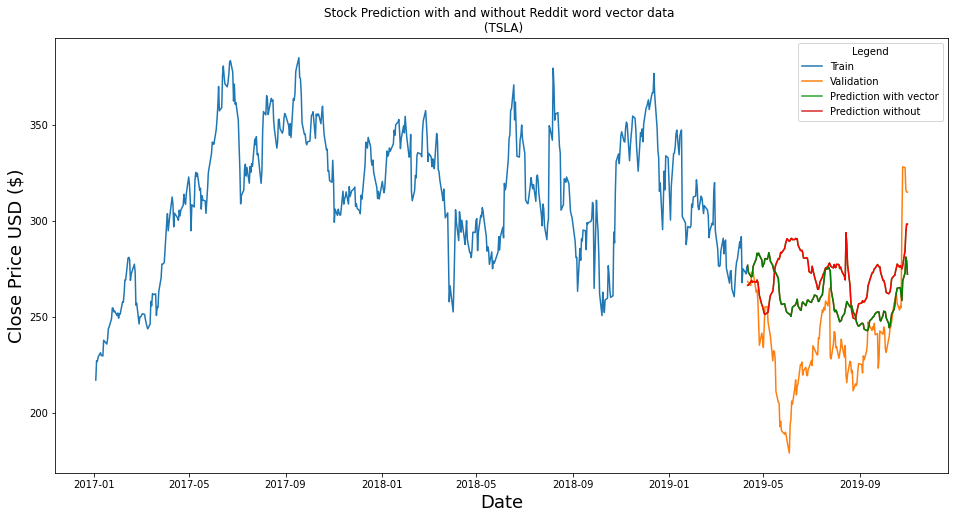

In [193]:
# Visualize data
plt.figure(figsize=(16,8))
plt.title('Stock Prediction with and without Reddit word vector data \n (TSLA)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(appleTest)
# plt.plot(appleValid)
# plt.plot(appleValid['Predictions'], color='red')
# plt.plot(appleValid['Predictions2'], color='green')
# plt.plot(amazonTest)
# plt.plot(amazonValid)
# plt.plot(amazonValid['Predictions'], color='red')
# plt.plot(amazonValid['Predictions2'], color='green')
# plt.plot(boeTest)
# plt.plot(boeValid)
# plt.plot(boeValid['Predictions'], color='red')
# plt.plot(boeValid['Predictions2'], color='green')
# plt.plot(spyTest, label='Train')
# plt.plot(spyValid, label='Actual')
# plt.plot(spyValid['Predictions'], label='Prediction with vector', color='red')
# plt.plot(spyValid['Predictions2'], label='Prediction without vector', color='green')

plt.plot(teslaTest, label='Train')
plt.plot(teslaValid, label="Actual")
plt.plot(teslaValid['Predictions'], label="vector prediction", color='red')
plt.plot(teslaValid['Predictions2'], label="without vector prediction", color="green")
plt.legend(('Train', 'Validation', 'Prediction with vector', 'Prediction without'), title="Legend",)
plt.show()